In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
import pickle


In [119]:
#leer el data
data = pd.read_csv('octavos_df.csv')
data.head()

,Equipo 1,Equipo 2,Temporada,goles_1,goles_2,goles_ida_1,goles_ida_2,goles_vuelta_2,goles_vuelta_1
0,Leipzig,Manchester City,22/23,1,8,1,1,0,7
1,Brujas,Benfica,22/23,1,7,0,2,1,5
2,Liverpool,Real Madrid,22/23,2,6,2,5,0,1
3,Milan,Tottenham Hotspur,22/23,1,0,1,0,0,0
4,Eintracht Fráncfort,Napoli,22/23,0,5,0,2,0,3


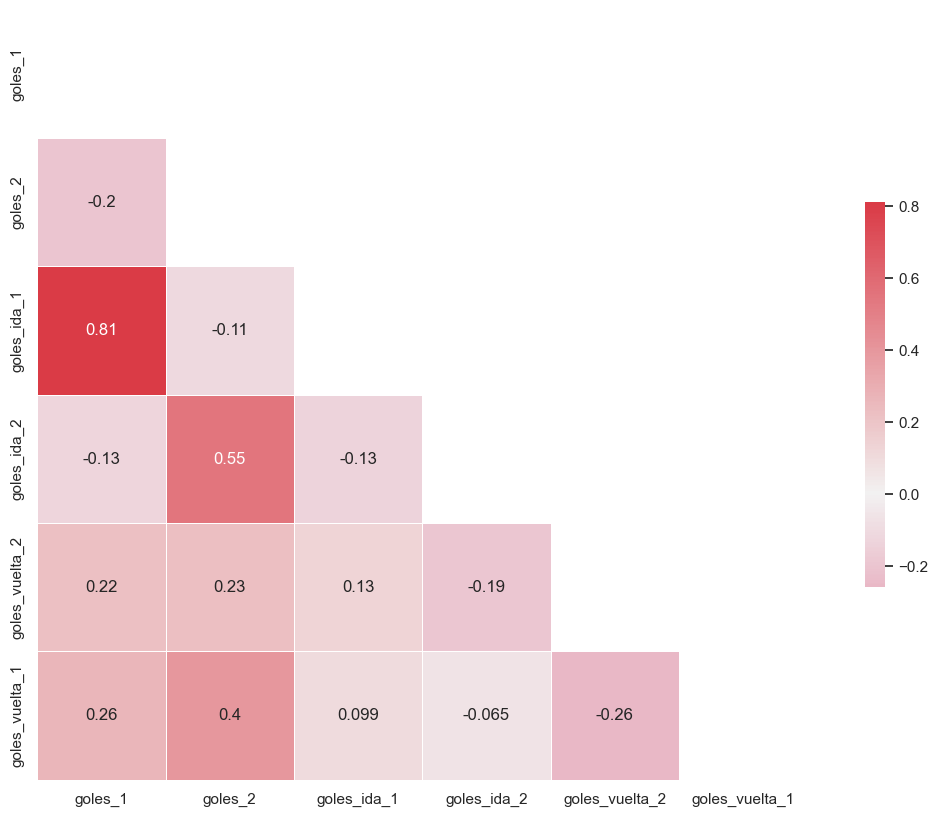

In [120]:
# Seleccionar solo las columnas numéricas
columnas_numericas = data.select_dtypes(include='number')

# Calcular la matriz de correlación
matriz_correlacion = columnas_numericas.corr()

# Crear el mapa de calor
plt.figure(figsize=(15, 10))
sns.set(style='white')

mask = np.triu(np.ones_like(matriz_correlacion, dtype=bool))
cmap = sns.diverging_palette(0, 10, as_cmap=True)

sns.heatmap(matriz_correlacion,
            mask=mask,
            cmap=cmap,
            center=0,
            square=True,
            annot=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.5})

plt.show()



In [121]:
#Las columnas no numéricas 'Equipo 1', 'Equipo 2' y 'Temporada' las paso a numéricas
#A cada equipos le asignaremos un número diferente (nuestro id) y para la temporada nos quedamos con el segundo año

import csv

equipos = set(data['Equipo 1']).union(set(data['Equipo 2']))
equipos_id = {equipo: i for i, equipo in enumerate(equipos)}

# Especificar el nombre del archivo CSV donde guardar la correspondencia
file_name = 'equipos_id.csv'

# Crear y escribir el archivo CSV
with open(file_name, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    
    # Escribir el encabezado
    writer.writerow(['Equipo', 'ID'])
    
    # Escribir cada equipo y su ID
    for equipo, id_equipo in equipos_id.items():
        writer.writerow([equipo, id_equipo])

print(f'Se guardó la correspondencia en {file_name}')

Se guardó la correspondencia en equipos_id.csv


In [122]:
#Una vez creados los ids hacemos el cambio en las columnas no numéricas

data['Equipo 1'] = data['Equipo 1'].map(equipos_id)
data['Equipo 2'] = data['Equipo 2'].map(equipos_id)
data['Temporada'] = data['Temporada'].apply(lambda x: int(x[-2:]))

# Guardar el DataFrame modificado en un mismo archivo CSV
data.to_csv('octavos_id.csv', index=False)

#Ahora mis equipos pasan a ser números

In [123]:
data.dtypes

Equipo 1          int64
Equipo 2          int64
Temporada         int64
goles_1           int64
goles_2           int64
goles_ida_1       int64
goles_ida_2       int64
goles_vuelta_2    int64
goles_vuelta_1    int64
dtype: object

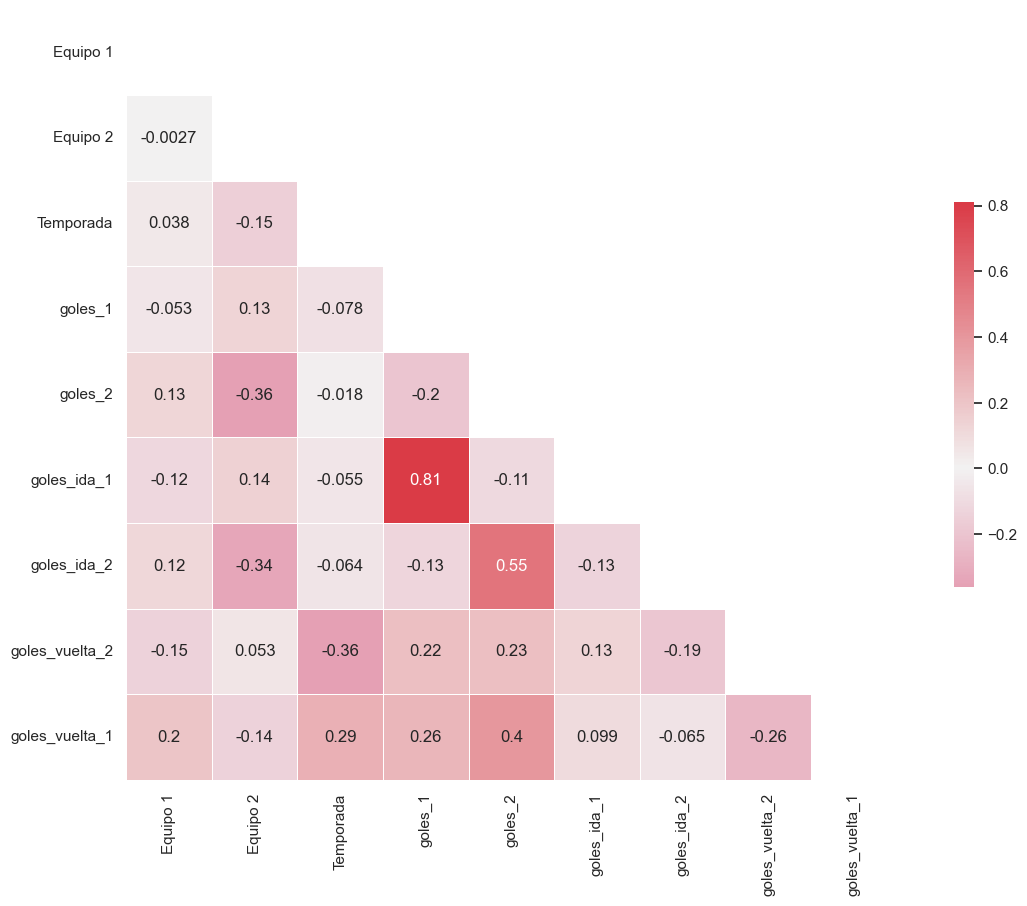

In [124]:
# Seleccionar solo las columnas numéricas
columnas_numericas = data.select_dtypes(include='number')

# Calcular la matriz de correlación
matriz_correlacion = columnas_numericas.corr()

# Crear el mapa de calor
plt.figure(figsize=(15, 10))
sns.set(style='white')

mask = np.triu(np.ones_like(matriz_correlacion, dtype=bool))
cmap = sns.diverging_palette(0, 10, as_cmap=True)

sns.heatmap(matriz_correlacion,
            mask=mask,
            cmap=cmap,
            center=0,
            square=True,
            annot=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.5})

plt.show()

### REGRESIÓN LINEAL para predecir primero los goles marcados por el equipo1, aprendizaje supervisado

In [125]:
df = pd.read_csv('octavos_id.csv')
df.head()

,Equipo 1,Equipo 2,Temporada,goles_1,goles_2,goles_ida_1,goles_ida_2,goles_vuelta_2,goles_vuelta_1
0,41,1,23,1,8,1,1,0,7
1,9,2,23,1,7,0,2,1,5
2,14,40,23,2,6,2,5,0,1
3,3,45,23,1,0,1,0,0,0
4,32,34,23,0,5,0,2,0,3


In [126]:
x = df.drop('goles_1', axis=1)
y = df['goles_1'] #Ahora vamos a predecir los goles del equipo 1, también podremos predecir los goles del equipo 2

In [127]:
#Dividimos los datos en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [128]:
#Normalizamos los datos de entrenamiento y los guardamos en un fichero para su uso futuro
pt = PowerTransformer()
pt.fit(x_train)
with open('/Users/carlotasanchezgonzalez/Documents/class/Champions_23-24/scalers/octavos_scaler.pkl', 'wb') as f:
    pickle.dump(pt, f)

In [129]:
#Normalizamos los datos para que se asemeje a una distribución normal y así mejorar el rendimiento del modelo
x_train_scaled = pt.transform(x_train)
x_test_scaled = pt.transform(x_test)

y_train_scaled = np.log1p(y_train)

#Y lo guardamos en dataframes
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x.columns)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x.columns)

x_train_scaled


,Equipo 1,Equipo 2,Temporada,goles_2,goles_ida_1,goles_ida_2,goles_vuelta_2,goles_vuelta_1
0,-0.006994,0.189225,-0.371385,-0.141698,-1.260946,0.615537,-0.128615,-1.280515
1,1.283465,-1.691702,-1.380766,1.240101,-1.260946,1.554102,0.634722,-0.129810
2,1.368085,0.137602,1.286741,-1.309766,0.871652,-1.364606,0.634722,-0.129810
3,1.066788,0.931630,0.626725,0.353156,-1.260946,-0.121332,-1.462661,0.995362
4,0.101660,1.220372,-0.037526,-0.141698,0.871652,0.615537,-0.128615,0.531436
...,...,...,...,...,...,...,...,...
65,-0.006994,0.189225,0.957236,0.353156,0.871652,-0.121332,0.634722,0.995362
66,0.259443,0.577566,-0.706491,0.810965,-1.260946,0.615537,1.168836,-0.129810
67,1.283465,0.802214,-1.042922,-1.309766,0.131700,-1.364606,-0.128615,-1.280515
68,-1.040594,-0.432957,1.286741,-0.687347,-1.260946,0.615537,-0.128615,-1.280515


In [130]:
#Ahora creo el modelod de regresión lineal y lo entrenamos
model = LinearRegression()
model.fit(x_train_scaled, y_train_scaled)

LinearRegression()

In [131]:
#Realizar predicciones 
y_pred = model.predict(x_test_scaled)
y_pred

array([1.52300074, 0.5898867 , 2.40556752, 1.68168967, 1.00668314,
       1.15996954, 1.33802911, 0.2154531 , 0.23308426, 0.80907862,
       1.1196474 , 0.06479397, 0.6162418 , 0.25483589, 0.80661475,
       1.46448492, 0.93441608, 0.95865772])

In [132]:
x_train
x_test

,Equipo 1,Equipo 2,Temporada,goles_2,goles_ida_1,goles_ida_2,goles_vuelta_2,goles_vuelta_1
76,22,31,14,5,2,4,1,2
0,41,1,23,8,1,1,0,7
26,11,21,20,4,4,1,4,3
22,42,31,21,5,2,3,2,2
12,38,53,22,1,1,1,1,0
67,51,40,15,5,0,2,3,4
10,2,20,22,2,2,2,1,0
18,38,52,21,3,0,1,0,2
4,32,34,23,5,0,2,0,3
68,1,33,15,3,1,2,1,0


In [133]:
#Evaluamos del modelo para ver la calidad de las predcciones

# Deshacer la transformación logarítmica para obtener las predicciones en la escala original
y_pred_original_scale = np.expm1(y_pred)

# Calcular el Error Cuadrático Medio (MSE)
mse = mean_squared_error(y_test, y_pred_original_scale)

# Calcular el Coeficiente de Determinación (R²)
r2 = r2_score(y_test, y_pred_original_scale)

# Calcular la Raíz del Error Cuadrático Medio (RMSE)
rmse = np.sqrt(mse)

# Imprimir las métricas
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Squared Error (MSE): 0.6151010852328178
R-squared (R²): 0.8397968234602629
Root Mean Squared Error (RMSE): 0.7842838040102689


Ahora voy a generar unos gráficos para que podamos ver visualmente el error en cada dato. En el caso de la gráfica de dispersión vemos cuanto se aleja cada dato de la recta de regresión, cuanto mas alejado esté mas error tiene. En el histograma podemos ver los residuos de cada dato.

    Actual  Predicted
76       4   3.585966
0        1   0.803784
26       8  10.084719
22       4   4.374630
12       2   1.736509
67       4   2.189836
10       3   2.811524
18       0   0.240424
4        0   0.262488
68       1   1.245838
85       3   2.063774
65       0   0.066939
53       2   0.851955
80       0   0.290250
84       1   1.240311
64       3   3.325315
33       2   1.545727
79       2   1.608193


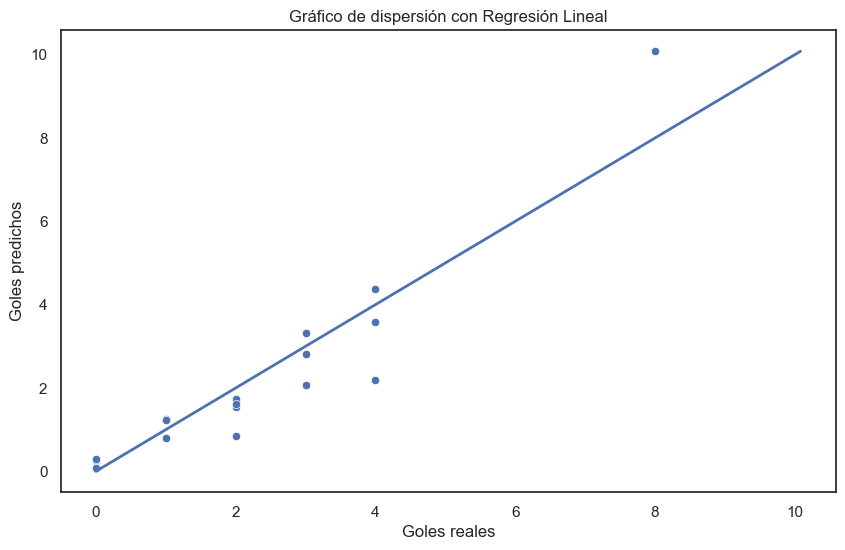

In [134]:
#Grafico de dispersion de los valores reales y las predicciones
#Deshacemos la transformación logarítmica para obtener las predicciones en la escala original
y_pred_original = np.expm1(y_pred)

# Crea un DataFrame con las predicciones y los valores reales
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_original})
print(results)

# Grafica de dispersión con la línea de regresión
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=results)
plt.plot([results.min().min(), results.max().max()], [results.min().min(), results.max().max()], linewidth=2)  # Línea de regresión
plt.title('Gráfico de dispersión con Regresión Lineal')
plt.xlabel('Goles reales')
plt.ylabel('Goles predichos')
plt.show()

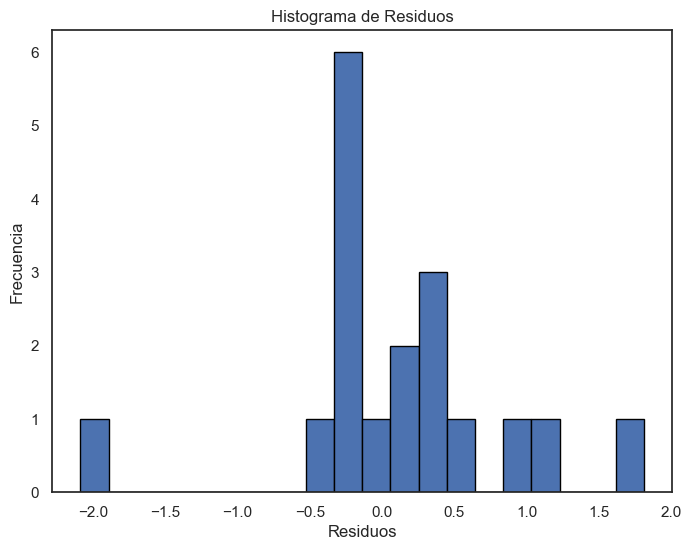

In [135]:
#Histograma de los residuos
# Calcular los residuos
residuos = y_test - y_pred_original

# Crear el histograma
plt.figure(figsize=(8, 6))
plt.hist(residuos, bins=20, edgecolor='black')
plt.title('Histograma de Residuos')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.show()

Podemos ver que en algunos casos el modelo tiene mas dificultades, pero en la mayoria de los datos el residuo entre -0.5 y 0.5. Lo ideal sería ver una distribución cercana a una campana de Gauss (distribución normal), lo que significa que los residuos están distribuidos de manera equitativa alrededor de cero.

### DECISSION TREE

In [136]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

#Crear el modelo de árbol de decisión, ponemos ese parámetro para que el modelo trate de minimizar el error cuadrático.
tree_model = DecisionTreeRegressor(criterion='squared_error')


In [137]:
#Entrenamos el modelo
tree_model.fit(x_train, y_train)

DecisionTreeRegressor()

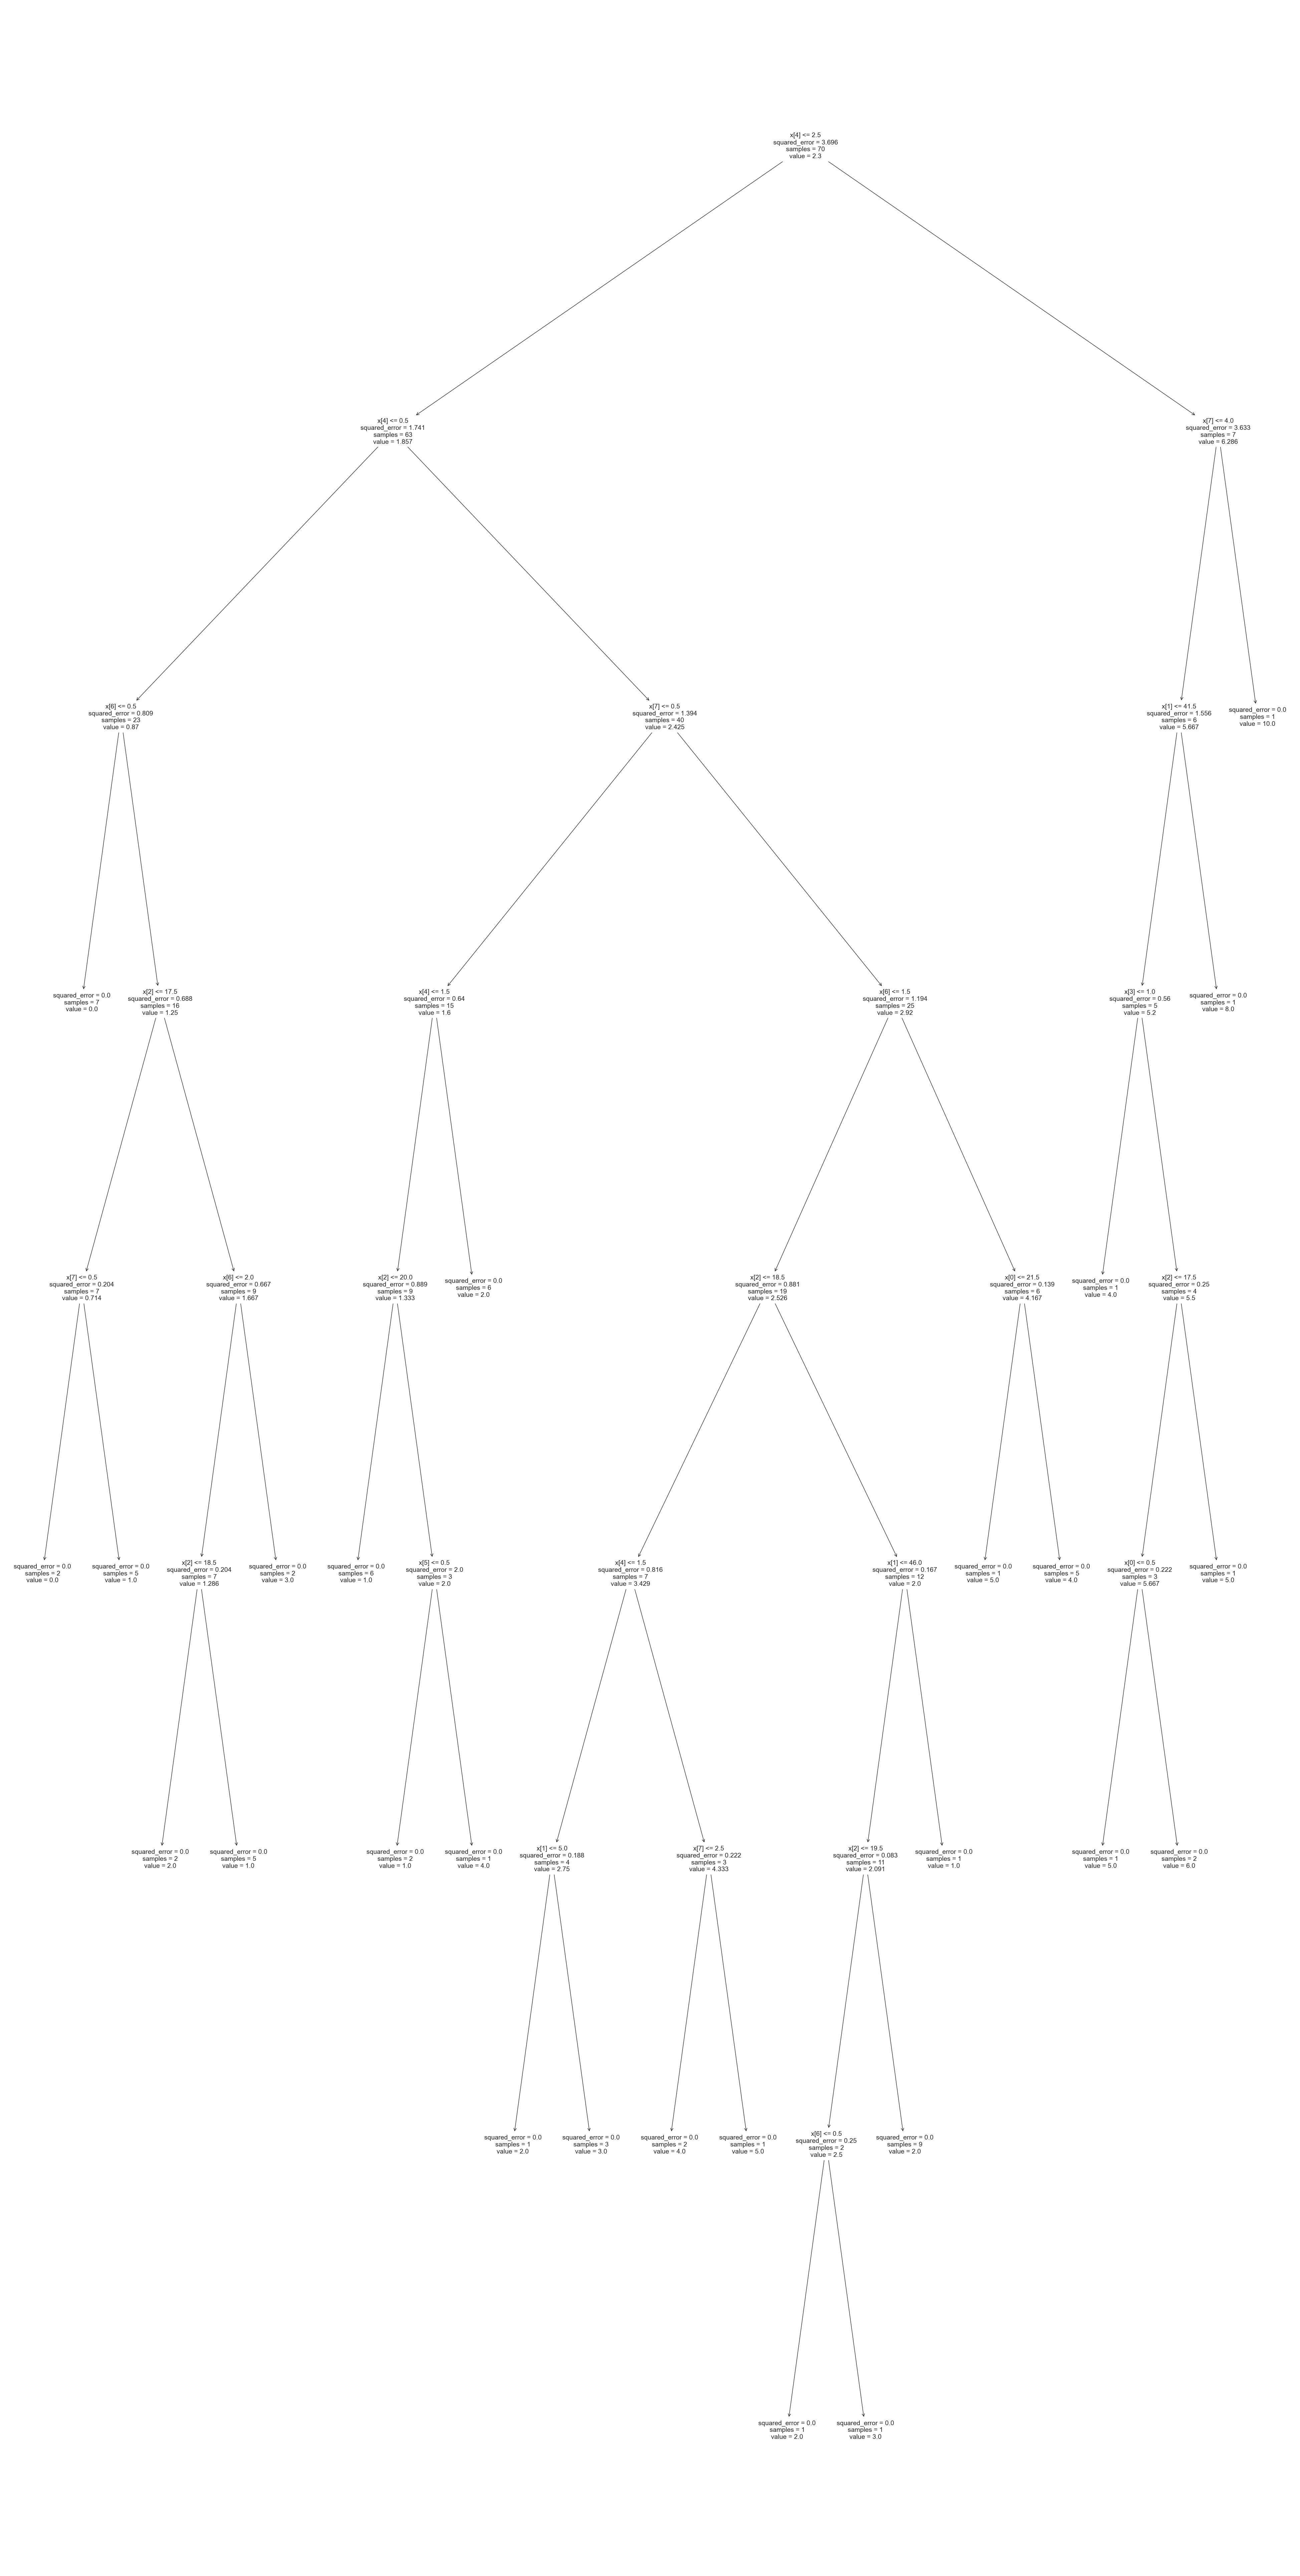

In [143]:
#Dibujamos el árbol
plt.figure(figsize=(50, 100))
plot_tree(tree_model, fontsize=14)
plt.show()

In [146]:
#Realizamos predicciones en el conjunto de prueba
y_pred_tree = tree_model.predict(x_test)

In [152]:
#Evaluación del modelo

mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print(f'Mean Squared Error (MSE) for Decision Tree: {mse_tree}')
print(f'R-squared (R²) for Decision Tree: {r2_tree}')

Mean Squared Error (MSE) for Decision Tree: 1.8333333333333333
R-squared (R²) for Decision Tree: 0.522508038585209


La regresión lineal parece tener un rendimiento superior en este conjunto de datos específico, según las métricas evaluadas.
La regresión lineal explica una mayor proporción de la variabilidad en la variable objetivo (según R^2) y tiene un MSE más bajo en comparación con el árbol de decisión.
Si bien el árbol de decisión puede ser útil, especialmente si hay relaciones no lineales en los datos, en este caso, la regresión lineal parece ser una opción más efectiva.